<a href="https://colab.research.google.com/github/p0mona/MAD_SWPS_Polina_Bezukladnova_3/blob/main/mad_p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [510]:
#Importuję wszystkie potrzebne biblioteki
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore, stats
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier

In [456]:
#Importuję dataset
url = 'https://raw.githubusercontent.com/p0mona/MAD_SWPS_Polina_Bezukladnova_3/refs/heads/main/apple_quality.csv'
apple: pd.DataFrame = pd.read_csv(url)

In [457]:
apple.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [458]:
#brakujące dane
apple[apple.isnull().any(axis=1)]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


In [459]:
# Usunięcie brakujących danych
apple = apple.drop(apple.index[-1])

In [460]:
#Ponowne sprawdzenie
apple[apple.isnull().any(axis=1)]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality


In [461]:
#Duplikaty
apple[apple.duplicated()]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality


In [462]:
#Zmienna zależna
dep_var = apple['Quality']

#Zmienne niezależne
indep_var = apple.drop(columns=['Quality', 'A_id'])

In [463]:
#Konwersja danych do tablic NumPy
dep_var_array = np.array(dep_var)
indep_var_array = np.array(indep_var)

In [464]:
# Analiza statystyczna
indep_var.describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


In [465]:
#Zauważyłam, że nie ma 'Acidity', sprawdzam typ danych
indep_var.dtypes

,0
Size,float64
Weight,float64
Sweetness,float64
Crunchiness,float64
Juiciness,float64
Ripeness,float64
Acidity,object


In [466]:
#'Acidity' typu object -> sprawdzam wartości
mask = pd.to_numeric(indep_var['Acidity'], errors='coerce').isna()
print(indep_var[mask])

Empty DataFrame
Columns: [Size, Weight, Sweetness, Crunchiness, Juiciness, Ripeness, Acidity]
Index: []


In [467]:
# Nie ma 'złych' wartości, dlatego mogę zmienić typ danych 'Acidity'
indep_var['Acidity'] = pd.to_numeric(indep_var['Acidity'])

In [468]:
# sprawdzam ponowmie describe()
indep_var.describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,0.076877
std,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,2.110270
min,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538
25%,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424
50%,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609
75%,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493
max,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736


In [469]:
mediana = indep_var.median(numeric_only=True)
print("Mediana:\n", mediana)

Mediana:
 Size          -0.513703
Weight        -0.984736
Sweetness     -0.504758
Crunchiness    0.998249
Juiciness      0.534219
Ripeness       0.503445
Acidity        0.022609
dtype: float64


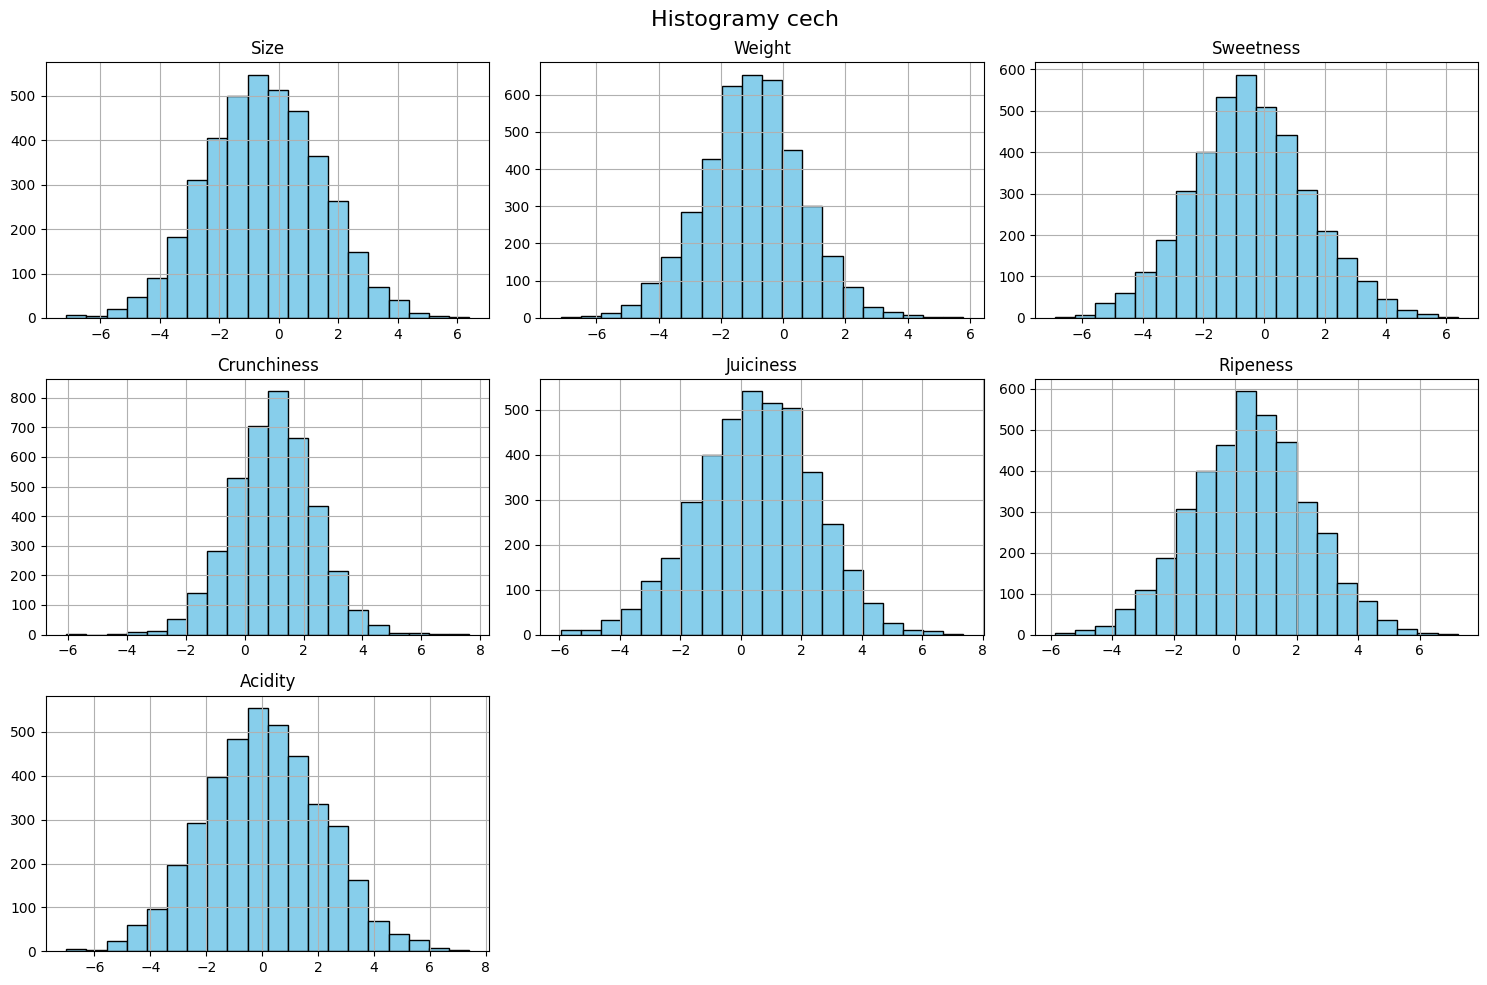

In [470]:
#Histogramy dla wszystkich zmiennych
indep_var.hist(bins=20, figsize=(15, 10), edgecolor='black', color='skyblue')
plt.suptitle("Histogramy cech", fontsize=16)
plt.tight_layout();

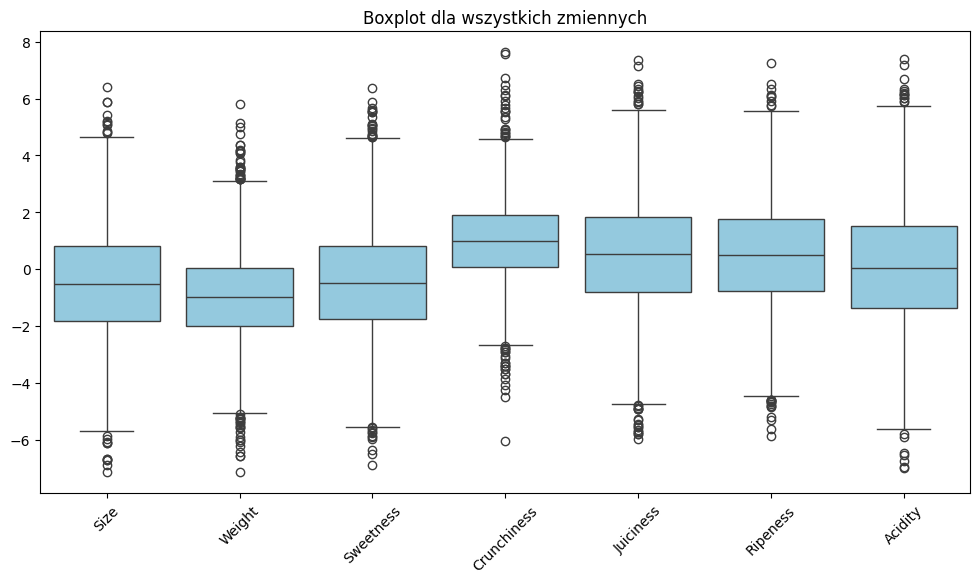

In [471]:
#Boxploty dla wszyskich zmiennych
plt.figure(figsize=(12, 6))
sns.boxplot(indep_var, color="skyblue")
plt.xticks(rotation=45)
plt.title('Boxplot dla wszystkich zmiennych');

In [472]:
#Macierz korelacji
matrix_corr = indep_var.corr()
print(matrix_corr)

                 Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
Size         1.000000 -0.170702  -0.324680     0.169868  -0.018892 -0.134773   
Weight      -0.170702  1.000000  -0.154246    -0.095882  -0.092263 -0.243824   
Sweetness   -0.324680 -0.154246   1.000000    -0.037552   0.095882 -0.273800   
Crunchiness  0.169868 -0.095882  -0.037552     1.000000  -0.259607 -0.201982   
Juiciness   -0.018892 -0.092263   0.095882    -0.259607   1.000000 -0.097144   
Ripeness    -0.134773 -0.243824  -0.273800    -0.201982  -0.097144  1.000000   
Acidity      0.196218  0.016414   0.085999     0.069943   0.248714 -0.202669   

              Acidity  
Size         0.196218  
Weight       0.016414  
Sweetness    0.085999  
Crunchiness  0.069943  
Juiciness    0.248714  
Ripeness    -0.202669  
Acidity      1.000000  


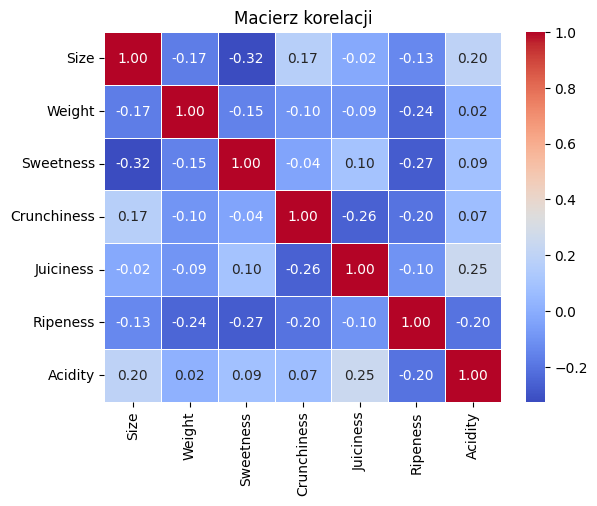

In [473]:
# Wizualizacji macierzy
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Macierz korelacji');

In [474]:
# Outliery, wybiram Z-score dlatego że mam rozkład normalny(histogram)
z_scores = np.abs(zscore(indep_var))
threshold = 3
outliers = (z_scores > threshold)

#ilość wartości odstających
print(outliers.sum())

102


In [475]:
#Usuwam wierszy z wartosciami odstającymi
indep_var_no_outliers = indep_var[~outliers.any(axis=1)]
dep_var_no_outliers = dep_var[~outliers.any(axis=1)]

In [476]:
# Analiza statystyczna po usunięciu wartości odstających
indep_var_no_outliers.describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
count,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000
mean,-0.511937,-0.990995,-0.471125,0.980617,0.519838,0.515593,0.073821
std,1.885896,1.550028,1.910246,1.334950,1.881195,1.839423,2.080966
min,-6.099551,-5.746384,-5.958315,-3.127340,-4.924983,-4.851519,-5.917900
25%,-1.816040,-1.997478,-1.729070,0.077895,-0.791251,-0.734297,-1.376742
50%,-0.524415,-0.984489,-0.504307,0.994335,0.528195,0.521532,0.021319
75%,0.774258,0.021622,0.790041,1.879203,1.825988,1.771178,1.499513
max,5.225383,3.772173,5.346330,4.937210,6.226448,6.102587,6.348870


In [477]:
mediana = indep_var_no_outliers.median(numeric_only=True)
print("Mediana:\n", mediana)

Mediana:
 Size          -0.524415
Weight        -0.984489
Sweetness     -0.504307
Crunchiness    0.994335
Juiciness      0.528195
Ripeness       0.521532
Acidity        0.021319
dtype: float64


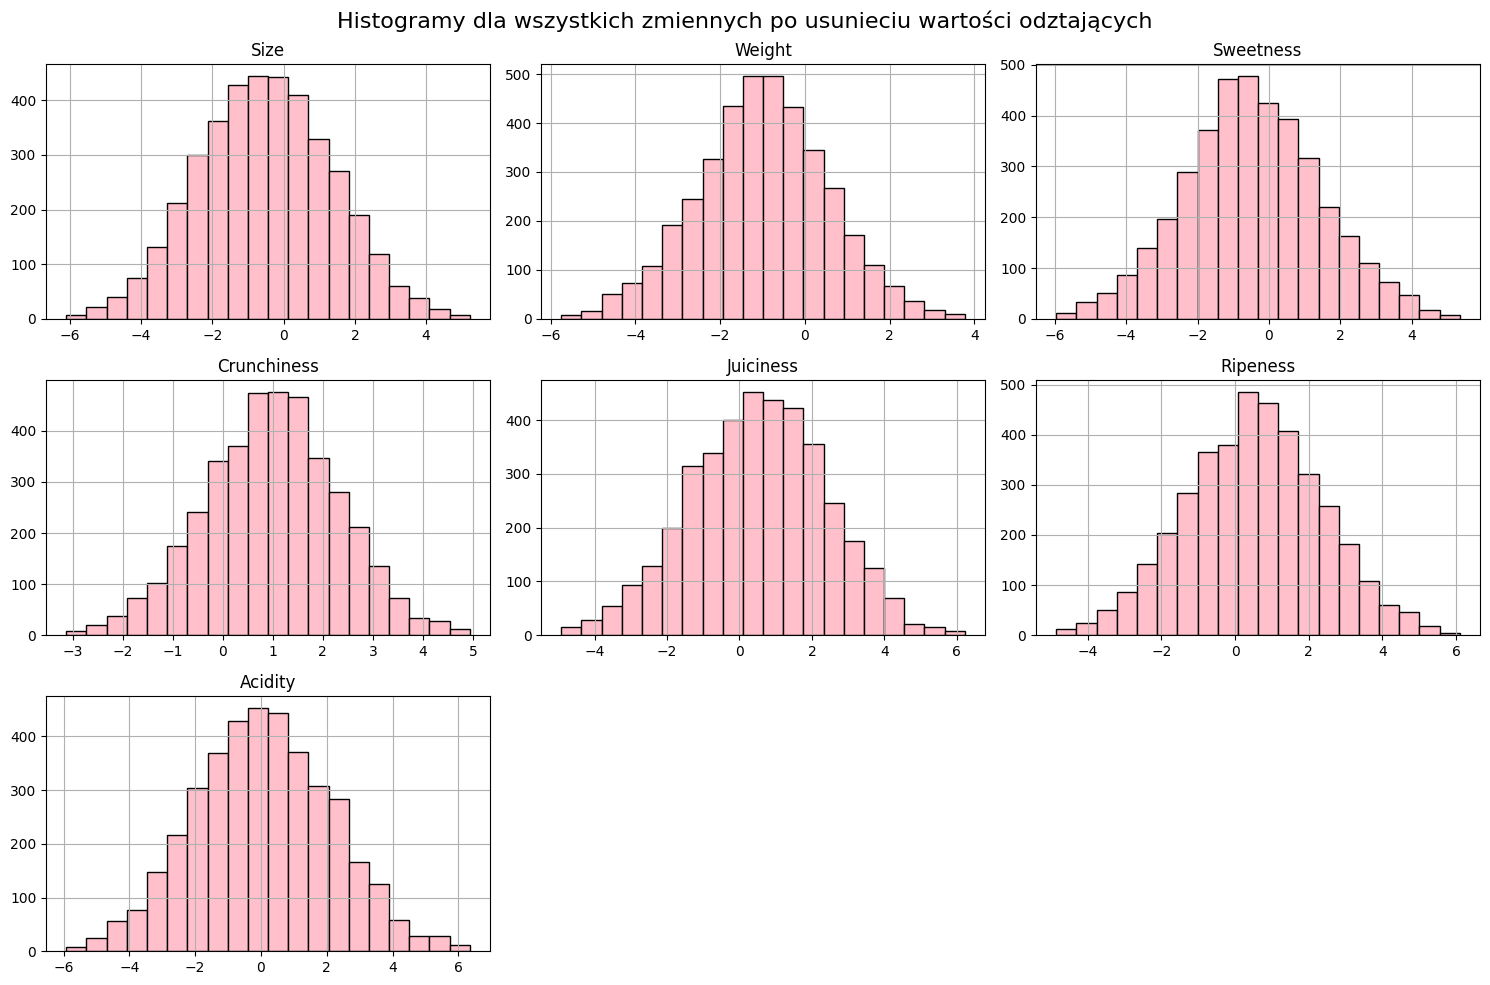

In [478]:
#Histogramy dla wszystkich zmiennych po usunieciu wartości odstających
indep_var_no_outliers.hist(bins=20, figsize=(15, 10), edgecolor='black', color='pink')
plt.suptitle("Histogramy dla wszystkich zmiennych po usunieciu wartości odztających", fontsize=16)
plt.tight_layout();

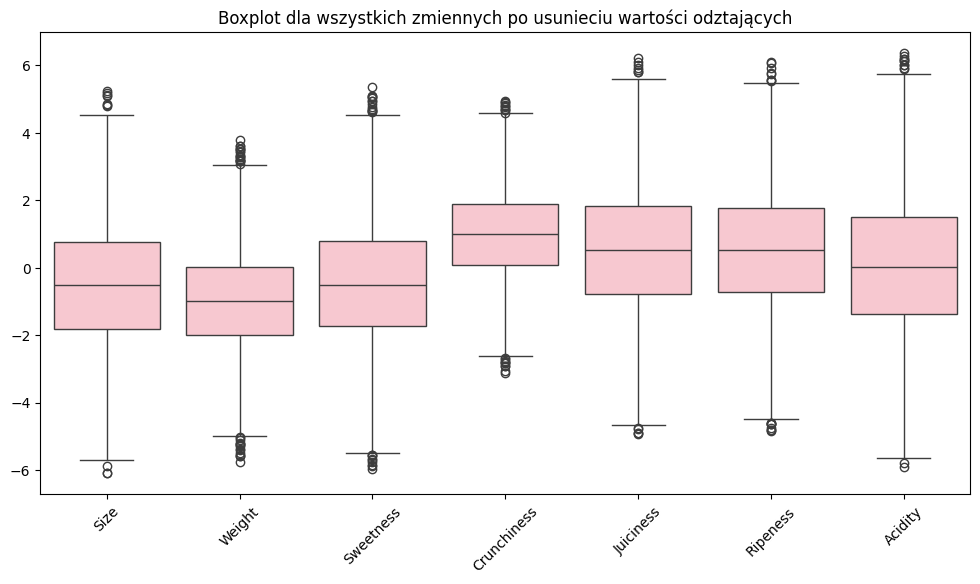

In [479]:
#Boxploty dla wszyskich zmiennych po usunieciu wartości odstających
plt.figure(figsize=(12, 6))
sns.boxplot(indep_var_no_outliers, color="pink")
plt.xticks(rotation=45)
plt.title('Boxplot dla wszystkich zmiennych po usunieciu wartości odztających');

In [480]:
#Macierz korelacji po usunieciu wartości odstających
matrix_corr = indep_var_no_outliers.corr()
print(matrix_corr)

                 Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
Size         1.000000 -0.153762  -0.324508     0.160858  -0.018156 -0.144195   
Weight      -0.153762  1.000000  -0.153337    -0.087360  -0.088784 -0.237118   
Sweetness   -0.324508 -0.153337   1.000000    -0.029287   0.084672 -0.272663   
Crunchiness  0.160858 -0.087360  -0.029287     1.000000  -0.242160 -0.198083   
Juiciness   -0.018156 -0.088784   0.084672    -0.242160   1.000000 -0.107505   
Ripeness    -0.144195 -0.237118  -0.272663    -0.198083  -0.107505  1.000000   
Acidity      0.185892  0.026974   0.073379     0.065757   0.244911 -0.198988   

              Acidity  
Size         0.185892  
Weight       0.026974  
Sweetness    0.073379  
Crunchiness  0.065757  
Juiciness    0.244911  
Ripeness    -0.198988  
Acidity      1.000000  


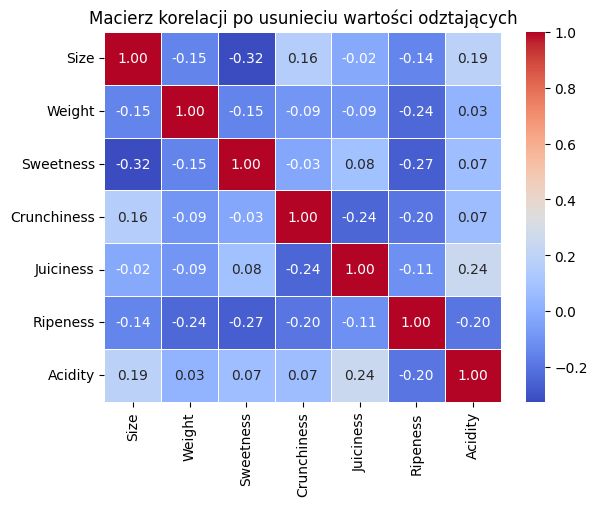

In [481]:
# Wizualizacji macierzy po usunieciu wartości odstających
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Macierz korelacji po usunieciu wartości odztających');

In [482]:
# Usuwam cechy z dyspersią < 0.1
selector = VarianceThreshold(threshold=0.01)
X_high_variance = selector.fit_transform(indep_var_no_outliers)

# Otrzymujemy nazwy pozostałych cech
selected_features = indep_var_no_outliers.columns[selector.get_support()]
X_selected = pd.DataFrame(X_high_variance, columns=selected_features)
X_selected

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984
...,...,...,...,...,...,...,...
3898,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784
3899,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235
3900,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611
3901,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720


In [483]:
#Zmieniam dane porządkowe na numeryczne
le = LabelEncoder()
dep_var_encoded = le.fit_transform(dep_var_no_outliers) #Label encoding

#Obliczam wzajemną informację (mutual information) między cechami a zmienną zależną
#Funkcja mutual_info_classif mierzy, jak bardzo każda cecha jest powiązana z celem (dep_var_encoded)
mi = mutual_info_classif(X_selected, dep_var_encoded)

# Tworzę serię pandas z nazwami cech i wartościami mutual information, sortuję malejąco
mi_series = pd.Series(mi, index=X_selected.columns).sort_values(ascending=False)

print(f"Wartości mutual_info: \n{mi_series}")

Wartości mutual_info: 
Juiciness      0.040286
Sweetness      0.040207
Ripeness       0.030347
Weight         0.027493
Size           0.024215
Crunchiness    0.022558
Acidity        0.000000
dtype: float64


In [484]:
#Wybieram tylko cechy, których wartość MI jest większa niż 0.02
important_features = mi_series[mi_series > 0.02].index
X_selected_filtered = X_selected[important_features]
important_features.tolist()

# - Acidity

['Juiciness', 'Sweetness', 'Ripeness', 'Weight', 'Size', 'Crunchiness']

In [485]:
# Sprawdzam, czy potrzebuję transformację danych
skewness = X_selected_filtered.skew() #Skośność kolumn
skewness

# -> Nie ma dużej skosności, dlatego nie potrzebuję transformacji

,0
Juiciness,-0.071841
Sweetness,0.058080
Ripeness,-0.006179
Weight,-0.032626
Size,0.024626
Crunchiness,-0.042739


In [486]:
#Skalowanie danych. StandardScaler() bo nie mam dużej skośności
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected_filtered)
X_scaled = pd.DataFrame(X_scaled, columns=X_selected_filtered.columns)
X_scaled

,Juiciness,Sweetness,Ripeness,Weight,Size,Crunchiness
0,0.704463,3.045786,-0.100997,-0.981619,-1.833905,-1.492851
1,0.177276,2.165016,0.191355,-1.192558,-0.362357,0.455218
2,1.232777,-0.663510,-0.301017,-0.232469,0.116624,-0.991350
3,1.657739,0.940313,-2.136462,-0.826305,-0.077034,-0.807993
4,1.334980,0.045270,-0.989264,-0.197194,0.994962,-1.148972
...,...,...,...,...,...,...
3898,0.626357,-1.698127,0.939797,-0.049304,0.302984,-0.380262
3899,-0.263332,0.139845,-0.871849,1.897143,0.116044,-1.214294
3900,0.893095,-1.031066,2.309861,-0.740244,-1.125645,-0.242283
3901,0.872747,1.485613,-0.163716,-0.508664,-1.854033,-0.884751


In [487]:
# Nie mam PCA(), bo mam tylko 6 cech, to nie jest dużo

In [488]:
#Sprawdzenie współliniowości (multikolinearności) przy użyciu wskaźnika VIF (Variance Inflation Factor)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
print(vif_data)
# -> Brak silnych korelacji między zmiennymi niezależnymi. Nie ma problemu z multikolinearnością

      Variable       VIF
0    Juiciness  1.122982
1    Sweetness  1.441209
2     Ripeness  1.461129
3       Weight  1.304886
4         Size  1.335983
5  Crunchiness  1.181534


In [489]:
# Podział danych na zbiór treningowy (80%) i testowy (20%)
# X_scaled - Zmienne niezależne
# dep_var_encoded - Zmienna zależna

X_train, X_test, y_train, y_test = train_test_split(X_scaled, dep_var_encoded, test_size=0.2, random_state=42)

# Sprawdzenie kształtu danych
print(f'Zbiór treningowy X: {X_train.shape}')
print(f'Zbiór testowy X: {X_test.shape}')
# 6 - liczba cech

Zbiór treningowy X: (3122, 6)
Zbiór testowy X: (781, 6)


#LogisticRegression()

In [490]:
#Trenowanie modelu (regresja logistyczna)
model = LogisticRegression(penalty='l2', C=1.0) #dlatego że mam Quality(0/1)
model.fit(X_train, y_train)

# fit - dopasowuje model do danych treningowych / optymalizuje parametry modelu w celu minimalizacji błędu
# penalty='l2' - L2-Ridge regularizacja
# C - hiperparametr

LogisticRegression()

In [491]:
y_pred = model.predict(X_test)

#Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
print('Macierz pomyłek:')
print(cm)

#Macierz pomyłek pokazuje, jak model klasyfikuje przypadki w czterech kategoriach: [[(R0, P0), (R0, P1)
#                                                                                   (R1, P0), (R1, P1)]]

Macierz pomyłek:
[[288 105]
 [102 286]]


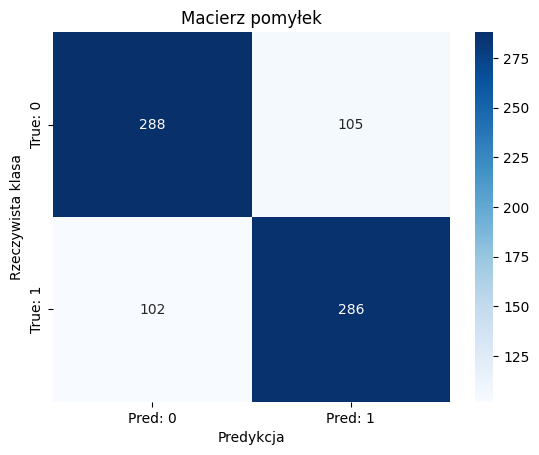

In [492]:
# Wizualizacja
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])
plt.title('Macierz pomyłek')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista klasa');

# То, что сверху - в порядке!


In [493]:
# Ocenianie dokładności modelu na zbiorze testowym
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       393
           1       0.73      0.74      0.73       388

    accuracy                           0.73       781
   macro avg       0.73      0.73      0.73       781
weighted avg       0.73      0.73      0.73       781



In [494]:
#Precision: spośród wszystkich obiektów _% rzeczywiście należy do tej klasy
#Recall: model poprawnie zaklasyfikował _% obiektów klasy _ spośród wszystkich obiektów tej klasy w danych
#F1-score: wskaźnik równowagi pomiędzy Precision a Recall. Wysoka precyzja i czułość prowadzi do wysokiego wyniku F1
#Accuracy: model poprawnie zaklasyfikował _% obiektów w zestawie testowym
#Macro AVG: średnia wartość metryk dla wszystkich klas, bez uwzględnienia ich częstotliwości
#Weighted AVG: średnia wartość ważona przez liczbę obiektów w każdej klasie

In [495]:
#Dostrajanie parametrów GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}

grid_search = GridSearchCV(model, param_grid, cv=5)  # cv=5 walidacja krzyżowa. Model jest trenowany na 5 grupach, a na 1 testowany
grid_search.fit(X_train, y_train)
print("Najlepszy hiperparametr:", grid_search.best_params_)

y_pred_best = grid_search.predict(X_test)
print(classification_report(y_test, y_pred_best))

Najlepszy hiperparametr: {'C': 1.0}
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       393
           1       0.73      0.74      0.73       388

    accuracy                           0.73       781
   macro avg       0.73      0.73      0.73       781
weighted avg       0.73      0.73      0.73       781



In [496]:
#łączenie etapów przetwarzania

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l2'))
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)
print(classification_report(y_test, y_pred_pipeline))



              precision    recall  f1-score   support

           0       0.74      0.73      0.74       393
           1       0.73      0.74      0.73       388

    accuracy                           0.73       781
   macro avg       0.73      0.73      0.73       781
weighted avg       0.73      0.73      0.73       781



#RandomForestClassifier()

In [497]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [498]:
y_pred = model.predict(X_test)

#Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
print('Macierz pomyłek:')
print(cm)

Macierz pomyłek:
[[329  64]
 [ 44 344]]


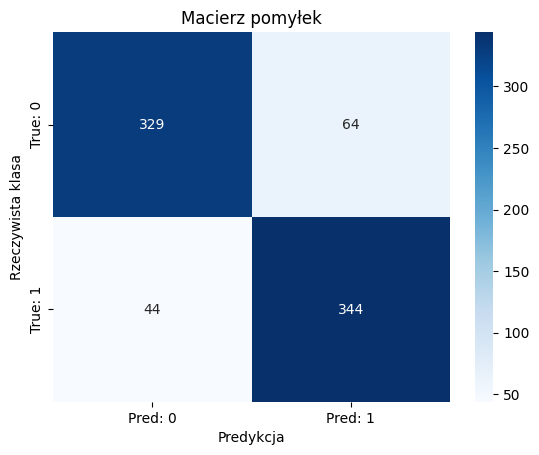

In [499]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])
plt.title('Macierz pomyłek')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista klasa');

In [500]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       393
           1       0.84      0.89      0.86       388

    accuracy                           0.86       781
   macro avg       0.86      0.86      0.86       781
weighted avg       0.86      0.86      0.86       781



In [509]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Najlepszy hiperparametry:", grid_search.best_params_)

y_pred_best = grid_search.predict(X_test)
print(classification_report(y_test, y_pred_best))

Najlepszy hiperparametry: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       393
           1       0.84      0.89      0.86       388

    accuracy                           0.86       781
   macro avg       0.86      0.86      0.86       781
weighted avg       0.86      0.86      0.86       781



In [507]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_train, y_train)

y_pred_pipeline_rf = pipeline_rf.predict(X_test)
print(classification_report(y_test, y_pred_pipeline_rf))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       393
           1       0.84      0.89      0.86       388

    accuracy                           0.86       781
   macro avg       0.86      0.86      0.86       781
weighted avg       0.86      0.86      0.86       781

